# Select Kernel

Remember to select the appropriate Kernel and virtual environment to run on.

# Install common packages in Terminal prior to running

pip install pandas
pip install numpy
pip install matplotlib
pip install seaborn
pip install scikit-learn
pip install scipy

To install all of the above at one time: 
pip install pandas numpy matplotlib seaborn scikit-learn scipy


In [2]:
#Load data
import pandas as pd
df = pd.read_csv('2025.09.29_2023_Sales_Transactions_Only.csv')

# Data Overview and Initial Processing

## Dataset Context
- Source: Sales transactions data for 2023 from Crafted Cones
- Timeframe: Full year 2023
- Scope: Individual transaction records including monetary values, quantities, and customer information

## Initial Data Loading Process
- Raw data loaded from CSV file without modifications
- No initial filtering or preprocessing applied
- Subsequent cells will handle data cleaning and validation

In [3]:
# Helper: clean numeric/currency columns
# Defines a reusable function to clean currency-like strings and coerce numeric columns.
# Call this early after loading the DataFrame so downstream cells receive numeric columns.

def clean_numeric_columns(df, currency_cols=None, numeric_cols=None, keep_raw=True, overwrite=True):
    import pandas as pd
    if currency_cols is None:
        currency_cols = []
    if numeric_cols is None:
        numeric_cols = []

    def _clean_currency_series(s):
        s2 = s.astype(str).str.strip()
        s2 = s2.replace('nan', '', regex=False)
        # detect parentheses for negatives
        neg_mask = s2.str.match(r'^\(.*\)$')
        # remove parentheses
        s2 = s2.str.replace(r'[\(\)]', '', regex=True)
        # remove dollar signs, commas and whitespace
        s2 = s2.str.replace(r'[\$,\s]', '', regex=True)
        # prefix negatives
        if neg_mask.any():
            s2.loc[neg_mask] = '-' + s2.loc[neg_mask]
        return pd.to_numeric(s2, errors='coerce')

    for col in currency_cols:
        if col in df.columns:
            if keep_raw:
                raw_col = f"{col}_raw"
                # only create raw copy if not exists
                if raw_col not in df.columns:
                    df[raw_col] = df[col]
            cleaned = _clean_currency_series(df[col])
            if overwrite:
                df[col] = cleaned
            else:
                df[f"{col}_clean"] = cleaned

    for col in numeric_cols:
        if col in df.columns:
            coerced = pd.to_numeric(df[col], errors='coerce')
            if overwrite:
                df[col] = coerced
            else:
                df[f"{col}_clean"] = coerced

    return df

# Example call: clean commonly problematic columns
# This will create `Total_Amount_raw` and `Unit_Price_raw` (if they don't exist) and
# create `Total_Amount_clean` and `Unit_Price_clean` columns (originals preserved).
clean_numeric_columns(df,
                      currency_cols=['Total_Amount','Unit_Price'],
                      numeric_cols=['Quantity','Number_of_Scoops','Year','Month'],
                      keep_raw=True,
                      overwrite=False)

print('Completed numeric cleaning: created *_clean columns; raw copies kept if not present.')


Completed numeric cleaning: created *_clean columns; raw copies kept if not present.


# Cleaning README: numeric cleaning contract


This notebook applies a small, deterministic cleaning step to common numeric/currency columns. Contract summary:


- Function: `clean_numeric_columns(df, currency_cols, numeric_cols, keep_raw=True, overwrite=False)`
- Behavior:
  - For each column in `currency_cols` (example: `['Total_Amount','Unit_Price']`):
    - Create `{col}_raw` if `keep_raw=True` and `{col}_raw` does not already exist.
    - Produce a cleaned numeric column named `{col}_clean` (unless `overwrite=True` is used).
    - Cleaning handles: trimming whitespace, removing `$` and `,`, converting `(123.45)` to `-123.45`, and coercing invalid values to `NaN`.
  - For each column in `numeric_cols` (example: `['Quantity','Number_of_Scoops','Year','Month']`):
    - Coerce values to numeric and write to `{col}_clean` (or overwrite original if `overwrite=True`).

- Post-condition: Analysis in this notebook should use `*_clean` columns (e.g., `Total_Amount_clean`, `Unit_Price_clean`, `Quantity_clean`, `Year_clean`, `Month_clean`).
- If `*_clean` is absent, some cells may attempt to create it from `{col}_raw` or, as a last resort, from the original `{col}` with a clear warning — but the preferred source is always `{col}_clean`.

Files produced by the notebook (examples): `total_amount_boxplot.png`, `total_amount_hist.png`.

If you want the cleaned dataset saved to disk, call `df.to_csv('cleaned_sales.csv', index=False)` after verifying the `*_clean` columns.

In [4]:
# Verification: show before/after samples for cleaned columns
print('Column list (first 50):', list(df.columns)[:50])

# Show Total_Amount raw vs clean
if 'Total_Amount_raw' in df.columns:
    print('\nTotal_Amount_raw (first 5):')
    print(df['Total_Amount_raw'].head().to_string())
else:
    print('\nNo Total_Amount_raw column present')

if 'Total_Amount_clean' in df.columns:
    print('\nTotal_Amount_clean (first 5):')
    print(df['Total_Amount_clean'].head().to_string())
    print(f"Total_Amount_clean - non-null count: {df['Total_Amount_clean'].count()} / {len(df)}")
else:
    print('\nNo Total_Amount_clean column present')

# Show Unit_Price raw vs clean
if 'Unit_Price_raw' in df.columns:
    print('\nUnit_Price_raw (first 5):')
    print(df['Unit_Price_raw'].head().to_string())
else:
    print('\nNo Unit_Price_raw column present')

if 'Unit_Price_clean' in df.columns:
    print('\nUnit_Price_clean (first 5):')
    print(df['Unit_Price_clean'].head().to_string())
    print(f"Unit_Price_clean - non-null count: {df['Unit_Price_clean'].count()} / {len(df)}")
else:
    print('\nNo Unit_Price_clean column present')

# Quick numeric summary of cleaned columns
import numpy as np
for c in ['Total_Amount_clean','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean']:
    if c in df.columns:
        print(f"\nSummary for {c}:")
        print(df[c].describe())
    else:
        print(f"\n{c} not present")


Column list (first 50): ['Transaction_ID', 'Customer_ID', 'Product_ID', 'Date', 'Date 2', 'Quantity', 'Unit_Price', 'Total_Amount', 'Payment_Method', 'Channel', 'Month', 'Year', 'Number_of_Scoops', 'Total_Amount_raw', 'Total_Amount_clean', 'Unit_Price_raw', 'Unit_Price_clean', 'Quantity_clean', 'Number_of_Scoops_clean', 'Year_clean', 'Month_clean']

Total_Amount_raw (first 5):
0     $10.00 
1     $18.00 
2      $9.00 
3     $21.00 
4     $14.00 

Total_Amount_clean (first 5):
0    10.0
1    18.0
2     9.0
3    21.0
4    14.0
Total_Amount_clean - non-null count: 37616 / 37616

Unit_Price_raw (first 5):
0     $5.00 
1     $6.00 
2     $4.50 
3     $7.00 
4     $7.00 

Unit_Price_clean (first 5):
0    5.0
1    6.0
2    4.5
3    7.0
4    7.0
Unit_Price_clean - non-null count: 37616 / 37616

Summary for Total_Amount_clean:
count    37616.000000
mean        11.445582
std          5.310280
min          4.000000
25%          6.500000
50%         11.000000
75%         15.000000
max         22.5

In [5]:
# Quick reload check for the cleaned dataset
import pandas as pd
import os
import hashlib

clean_path = 'cleaned_sales.csv'
print('Checking cleaned file:', clean_path)
if not os.path.exists(clean_path):
    print(f"File not found: {clean_path}. Run the cell that saves the cleaned CSV first.")
else:
    size = os.path.getsize(clean_path)
    # compute sha256 to detect accidental changes
    h = hashlib.sha256()
    with open(clean_path, 'rb') as fh:
        for chunk in iter(lambda: fh.read(8192), b''):
            h.update(chunk)
    sha256 = h.hexdigest()
    print(f"Exists: True  Size(bytes): {size}  SHA256: {sha256}")

    # Load a small sample to validate dtypes quickly
    sample = pd.read_csv(clean_path, nrows=1000)
    print('\nSample load OK — shape (sample):', sample.shape)
    print('\nDtypes (sample):')
    print(sample.dtypes)

    # Lightweight checks on important cleaned columns
    cols = [c for c in ['Total_Amount_clean','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean','Year_clean','Month_clean'] if c in sample.columns]
    if cols:
        print('\nQuick summary for cleaned columns (sample):')
        print(sample[cols].agg(['count','mean','std']).transpose())
    else:
        print('\nNo expected *_clean columns found in sample — check the saved file and the cleaning steps.')

    print('\nYou can now re-load the full cleaned dataset with: df = pd.read_csv("cleaned_sales.csv")')


Checking cleaned file: cleaned_sales.csv
Exists: True  Size(bytes): 4753284  SHA256: d9131b54ab97b110b70fca59d16dd80ec0ebac479e3b42680b2968a7de47084c

Sample load OK — shape (sample): (1000, 21)

Dtypes (sample):
Transaction_ID             object
Customer_ID                object
Product_ID                 object
Date                       object
Date 2                     object
Quantity                    int64
Unit_Price                 object
Total_Amount               object
Payment_Method             object
Channel                    object
Month                       int64
Year                        int64
Number_of_Scoops            int64
Total_Amount_raw           object
Total_Amount_clean        float64
Unit_Price_raw             object
Unit_Price_clean          float64
Quantity_clean              int64
Number_of_Scoops_clean      int64
Year_clean                  int64
Month_clean                 int64
dtype: object

Quick summary for cleaned columns (sample):
              

In [6]:
#Confirm data load and show cleaned columns (if present)
to_show = []
for c in ['Total_Amount_raw','Total_Amount_clean','Unit_Price_raw','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean']:
    if c in df.columns:
        to_show.append(c)

if to_show:
    print('Showing head() for cleaned/raw columns:')
    display_cols = df[to_show].head()
    print(display_cols)
else:
    print('No cleaned/raw sample columns present; showing regular head()')
    print(df.head())

Showing head() for cleaned/raw columns:
  Total_Amount_raw  Total_Amount_clean Unit_Price_raw  Unit_Price_clean  \
0          $10.00                 10.0         $5.00                5.0   
1          $18.00                 18.0         $6.00                6.0   
2           $9.00                  9.0         $4.50                4.5   
3          $21.00                 21.0         $7.00                7.0   
4          $14.00                 14.0         $7.00                7.0   

   Quantity_clean  Number_of_Scoops_clean  
0               2                       2  
1               3                       3  
2               2                       1  
3               3                       4  
4               2                       4  


In [7]:
#Confirm dataset volume 
print(df.shape)

(37616, 21)


In [8]:
#(1)DATA UNDERSTANDING 
#Check Data types
print(df.dtypes)

Transaction_ID             object
Customer_ID                object
Product_ID                 object
Date                       object
Date 2                     object
Quantity                    int64
Unit_Price                 object
Total_Amount               object
Payment_Method             object
Channel                    object
Month                       int64
Year                        int64
Number_of_Scoops            int64
Total_Amount_raw           object
Total_Amount_clean        float64
Unit_Price_raw             object
Unit_Price_clean          float64
Quantity_clean              int64
Number_of_Scoops_clean      int64
Year_clean                  int64
Month_clean                 int64
dtype: object


In [9]:
#(2) DATA CLEANING 
#Get missing data per col 
missing_counts_per_column = df.isnull().sum() 

print(missing_counts_per_column)

Transaction_ID               0
Customer_ID                  0
Product_ID                   0
Date                         0
Date 2                       0
Quantity                     0
Unit_Price                   0
Total_Amount                 0
Payment_Method               0
Channel                   7586
Month                        0
Year                         0
Number_of_Scoops             0
Total_Amount_raw             0
Total_Amount_clean           0
Unit_Price_raw               0
Unit_Price_clean             0
Quantity_clean               0
Number_of_Scoops_clean       0
Year_clean                   0
Month_clean                  0
dtype: int64


In [10]:
#(4) OUTLIER DETECTION 
# Prefer working on `Total_Amount_clean`. If missing, attempt to create from
# `Total_Amount_raw`. Only as a last-resort fallback will the original
# `Total_Amount` be used (with a warning).

def _ensure_total_amount_clean(df):
    # If clean exists, nothing to do
    if 'Total_Amount_clean' in df.columns:
        return

    # Try to create from raw copy if it exists
    if 'Total_Amount_raw' in df.columns:
        temp = df['Total_Amount_raw'].astype(str).str.strip()
        temp = temp.replace('nan', '', regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]', '', regex=True)
        temp = temp.str.replace(r'[\$,\s]', '', regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
        print('Created Total_Amount_clean from Total_Amount_raw')
        return

    # Last-resort: if original column exists, create raw and clean but warn
    if 'Total_Amount' in df.columns:
        print('Warning: creating Total_Amount_clean from original Total_Amount (no raw copy present).')
        temp = df['Total_Amount'].astype(str).str.strip()
        temp = temp.replace('nan', '', regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]', '', regex=True)
        temp = temp.str.replace(r'[\$,\s]', '', regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        # create raw copy then create clean
        df['Total_Amount_raw'] = df['Total_Amount']
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
        return

    # If we reach here, there's no source to create Total_Amount_clean
    raise RuntimeError('No Total_Amount column (raw or original) found to create Total_Amount_clean')


_ensure_total_amount_clean(df)

# Diagnostics: dtype and count of coerced (NaN) values
print(f"dtype of Total_Amount_clean: {df['Total_Amount_clean'].dtype}")
n_coerced = df['Total_Amount_clean'].isna().sum()
print(f"Number of rows where Total_Amount_clean could not be converted and were set to NaN: {n_coerced}")
if n_coerced > 0:
    print("Sample rows with non-numeric Total_Amount after coercion:")
    print(df[df['Total_Amount_clean'].isna()].head())

# Work with cleaned numeric values only
column_to_analyze = df['Total_Amount_clean'].dropna()

if column_to_analyze.empty:
    print("No numeric values available in 'Total_Amount_clean' after conversion. Cannot compute IQR.")
else:
    # Calculate Q1
    Q1 = column_to_analyze.quantile(0.25)

    # Calculate Q3
    Q3 = column_to_analyze.quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define the outlier boundaries (using the standard 1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print("--- IQR Results for Total_Amount_clean ---")
    print(f"First Quartile (Q1): {Q1}")
    print(f"Third Quartile (Q3): {Q3}")
    print(f"Interquartile Range (IQR): {IQR}")
    print(f"Lower Bound (Outliers below): {lower_bound}")
    print(f"Upper Bound (Outliers above): {upper_bound}")

    # Find and print the outliers using the cleaned column
    outliers = df[(df['Total_Amount_clean'] < lower_bound) | (df['Total_Amount_clean'] > upper_bound)]
    print(f"\nNumber of Outliers Found: {len(outliers)}")
    # Use .head() to avoid printing all rows if you have many outliers
    print(f"First 5 Outlier Transactions:\n{outliers.head()}")

# ----------------------------
# Alternative outlier detection methods and visualization (operate on Total_Amount_clean)
# Create a clean column for alternative analyses if not already present (ensured above)

# 1) Z-score method (use population std, threshold configurable)
mean_val = df['Total_Amount_clean'].mean()
std_val = df['Total_Amount_clean'].std(ddof=0)
if pd.isna(std_val) or std_val == 0:
    z_scores = pd.Series([0]*len(df))
else:
    z_scores = (df['Total_Amount_clean'] - mean_val) / std_val
z_threshold = 3.0
outliers_z = df[z_scores.abs() > z_threshold]
print(f"\nZ-score method (|z| > {z_threshold}): {len(outliers_z)} outliers")

# 2) Trimmed / scaled IQR method (allow multiplier > 1.5)
multiplier = 3.0  # change to 1.5 for standard rule, raise to find more extreme outliers
Q1_t = df['Total_Amount_clean'].quantile(0.25)
Q3_t = df['Total_Amount_clean'].quantile(0.75)
IQR_t = Q3_t - Q1_t
lower_t = Q1_t - multiplier * IQR_t
upper_t = Q3_t + multiplier * IQR_t
outliers_trimmed = df[(df['Total_Amount_clean'] < lower_t) | (df['Total_Amount_clean'] > upper_t)]
print(f"Trimmed IQR method (multiplier={multiplier}): {len(outliers_trimmed)} outliers (bounds {lower_t} to {upper_t})")

# 3) Visualizations: boxplot and histogram (saved to PNG files)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Total_Amount_clean'].dropna())
plt.title('Boxplot of Total_Amount (clean)')
plt.savefig('total_amount_boxplot.png', bbox_inches='tight')
plt.close()
# Histogram with KDE
plt.figure(figsize=(8,4))
sns.histplot(df['Total_Amount_clean'].dropna(), kde=True, bins=30)
plt.title('Histogram of Total_Amount (clean)')
plt.xlabel('Total_Amount')
plt.savefig('total_amount_hist.png', bbox_inches='tight')
plt.close()
print('Saved plots: total_amount_boxplot.png, total_amount_hist.png')

# Print small samples of outliers for quick inspection
print('\nSample outliers by method:')
print('Z-score (first 5):')
print(outliers_z.head().to_string())
print('\nTrimmed IQR (first 5):')
print(outliers_trimmed.head().to_string())
# ----------------------------

dtype of Total_Amount_clean: float64
Number of rows where Total_Amount_clean could not be converted and were set to NaN: 0
--- IQR Results for Total_Amount_clean ---
First Quartile (Q1): 6.5
Third Quartile (Q3): 15.0
Interquartile Range (IQR): 8.5
Lower Bound (Outliers below): -6.25
Upper Bound (Outliers above): 27.75

Number of Outliers Found: 0
First 5 Outlier Transactions:
Empty DataFrame
Columns: [Transaction_ID, Customer_ID, Product_ID, Date, Date 2, Quantity, Unit_Price, Total_Amount, Payment_Method, Channel, Month, Year, Number_of_Scoops, Total_Amount_raw, Total_Amount_clean, Unit_Price_raw, Unit_Price_clean, Quantity_clean, Number_of_Scoops_clean, Year_clean, Month_clean]
Index: []

[0 rows x 21 columns]

Z-score method (|z| > 3.0): 0 outliers
Trimmed IQR method (multiplier=3.0): 0 outliers (bounds -19.0 to 40.5)
Saved plots: total_amount_boxplot.png, total_amount_hist.png

Sample outliers by method:
Z-score (first 5):
Empty DataFrame
Columns: [Transaction_ID, Customer_ID, Prod

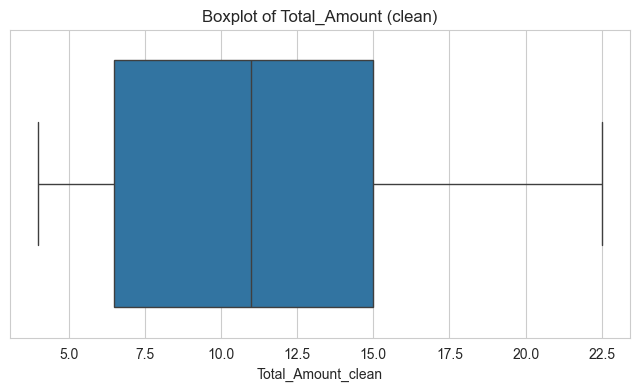

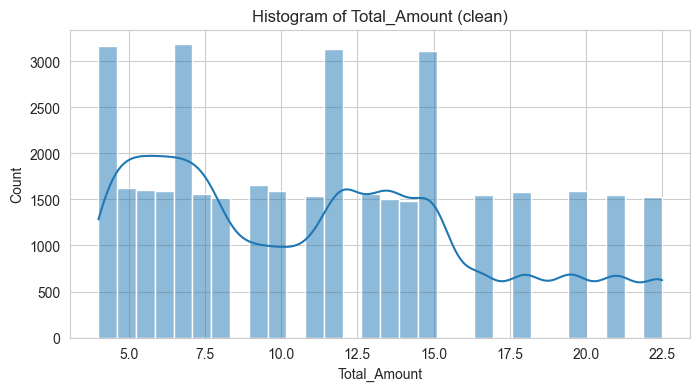

In [11]:
# Display generated plots inline
from IPython.display import Image, display
import os

files = ['total_amount_boxplot.png', 'total_amount_hist.png']
for f in files:
    if os.path.exists(f):
        display(Image(filename=f))
    else:
        print(f"File not found in workspace: {f}")


In [12]:
# (5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS
# Frequency of Year (use Year_clean when available)
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
frequency_table = df[year_col].value_counts()

print("--- Frequency Count ---")
print(frequency_table)

print("\n--- Relative Frequency (Percentage) ---")
# Get the percentage/proportion of each unique value
relative_frequency_table = df[year_col].value_counts(normalize=True) * 100
print(relative_frequency_table)

# Helper function to get clean column if available
def pick_clean(df, col):
    clean_col = f"{col}_clean"
    return df[clean_col] if clean_col in df.columns else df[col]

# Get clean versions of columns
safe_total = pick_clean(df, 'Total_Amount')
safe_qty = pick_clean(df, 'Quantity')
safe_price = pick_clean(df, 'Unit_Price')
safe_scoops = pick_clean(df, 'Number_of_Scoops')

def safe_print_mean(series, name):
    numeric = pd.to_numeric(series, errors='coerce')
    n_total = len(series)
    n_numeric = numeric.count()
    n_non_numeric = n_total - n_numeric
    mean_val = numeric.mean()
    print(f"{name} Mean: {mean_val} (non-numeric coerced to NaN: {n_non_numeric})")

print("\n--- Column Means ---")
safe_print_mean(safe_total, 'Total_Amount')
safe_print_mean(safe_qty, 'Quantity')
safe_print_mean(safe_price, 'Unit_Price')
safe_print_mean(safe_scoops, 'Number_of_Scoops')

--- Frequency Count ---
Year_clean
2023    37616
Name: count, dtype: int64

--- Relative Frequency (Percentage) ---
Year_clean
2023    100.0
Name: proportion, dtype: float64

--- Column Means ---
Total_Amount Mean: 11.445581667375585 (non-numeric coerced to NaN: 0)
Quantity Mean: 1.9913866439812846 (non-numeric coerced to NaN: 0)
Unit_Price Mean: 5.74670353041259 (non-numeric coerced to NaN: 0)
Number_of_Scoops Mean: 2.4958528285835815 (non-numeric coerced to NaN: 0)


In [13]:
# (5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS
# Frequency of Month AND Year (use cleaned columns when available)
month_col = 'Month_clean' if 'Month_clean' in df.columns else 'Month'
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
grouped_frequency = df.groupby([month_col, year_col]).size().reset_index(name='Count')

# Get the total number of rows in dataframe
total_count = len(df)

# Calculate the percentage column
grouped_frequency['Percentage'] = (grouped_frequency['Count'] / total_count) * 100

# Rounding to two decimal places
grouped_frequency['Percentage'] = grouped_frequency['Percentage'].round(2)

print("--- Month and Year Frequency ---")
print(grouped_frequency)

--- Month and Year Frequency ---
    Month_clean  Year_clean  Count  Percentage
0             1        2023   1913        5.09
1             2        2023   1800        4.79
2             3        2023   1929        5.13
3             4        2023   1764        4.69
4             5        2023   1671        4.44
5             6        2023   6890       18.32
6             7        2023   7384       19.63
7             8        2023   6579       17.49
8             9        2023   1821        4.84
9            10        2023   1810        4.81
10           11        2023   2013        5.35
11           12        2023   2042        5.43


In [14]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Frenquency of Month AND Year
grouped_frequency = df.groupby(['Month', 'Year']).size().reset_index(name='Count')

#Get the total number of rows in dataframe 
total_count = len(df) 

#Calculate the percentage column
grouped_frequency['Percentage'] = (grouped_frequency['Count'] / total_count) * 100

# Rounding to two decimal places
grouped_frequency['Percentage'] = grouped_frequency['Percentage'].round(2)

print(grouped_frequency)

    Month  Year  Count  Percentage
0       1  2023   1913        5.09
1       2  2023   1800        4.79
2       3  2023   1929        5.13
3       4  2023   1764        4.69
4       5  2023   1671        4.44
5       6  2023   6890       18.32
6       7  2023   7384       19.63
7       8  2023   6579       17.49
8       9  2023   1821        4.84
9      10  2023   1810        4.81
10     11  2023   2013        5.35
11     12  2023   2042        5.43


In [15]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Frenquency of Customer_ID. Aim to confirm there isn't any outliers among customers. 
frequency_table = df['Customer_ID'].value_counts()

print("--- Frequency Count ---")
print(frequency_table)

print("\n--- Relative Frequency (Percentage) ---")
# Get the percentage/proportion of each unique value
relative_frequency_table = df['Customer_ID'].value_counts(normalize=True) * 100

print(relative_frequency_table)

--- Frequency Count ---
Customer_ID
CUST033991    8
CUST014154    8
CUST021510    8
CUST024949    7
CUST014478    7
             ..
CUST013880    1
CUST015906    1
CUST033838    1
CUST023608    1
CUST011906    1
Name: count, Length: 21415, dtype: int64

--- Relative Frequency (Percentage) ---
Customer_ID
CUST033991    0.021268
CUST014154    0.021268
CUST021510    0.021268
CUST024949    0.018609
CUST014478    0.018609
                ...   
CUST013880    0.002658
CUST015906    0.002658
CUST033838    0.002658
CUST023608    0.002658
CUST011906    0.002658
Name: proportion, Length: 21415, dtype: float64


In [16]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Min and Max Customer_ID count. What is the min and max times a customer has attended Crafted Cones? 
import pandas as pd

#Attendance per customer 
attendance_counts = df.groupby('Customer_ID').size().reset_index(name='Attendance_Count')

#Min and max values from the new 'Attendance_Count' column
min_max_attendance = attendance_counts['Attendance_Count'].agg(['min', 'max'])

print("--- Min and Max Customer Attendance ---")
print(min_max_attendance)

--- Min and Max Customer Attendance ---
min    1
max    8
Name: Attendance_Count, dtype: int64


In [17]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Average and Median customer attendance 

# Group by customer attendance count 
attendance_counts = df.groupby('Customer_ID').size().reset_index(name='Attendance_Count')

#Find the mean and median of attendance counts
average_median_attendance = attendance_counts['Attendance_Count'].agg(['mean', 'median'])

print("--- Average and Median Customer Attendance ---")
print(average_median_attendance)

--- Average and Median Customer Attendance ---
mean      1.756526
median    1.000000
Name: Attendance_Count, dtype: float64


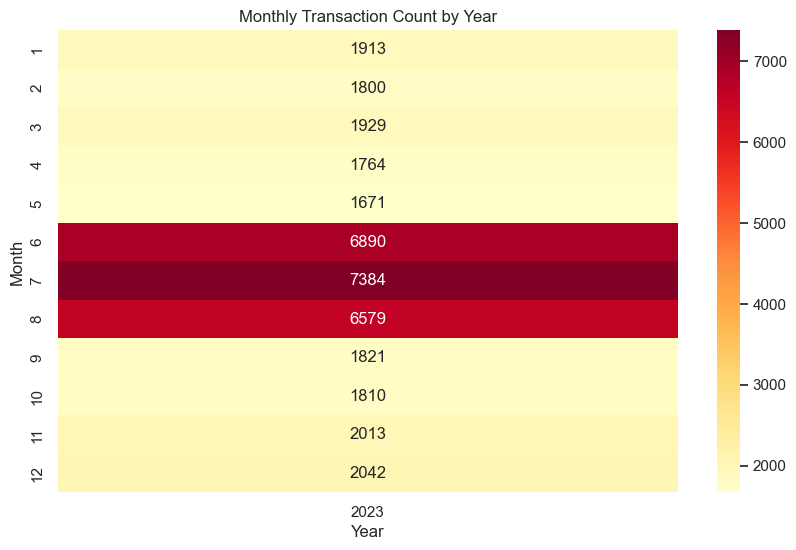

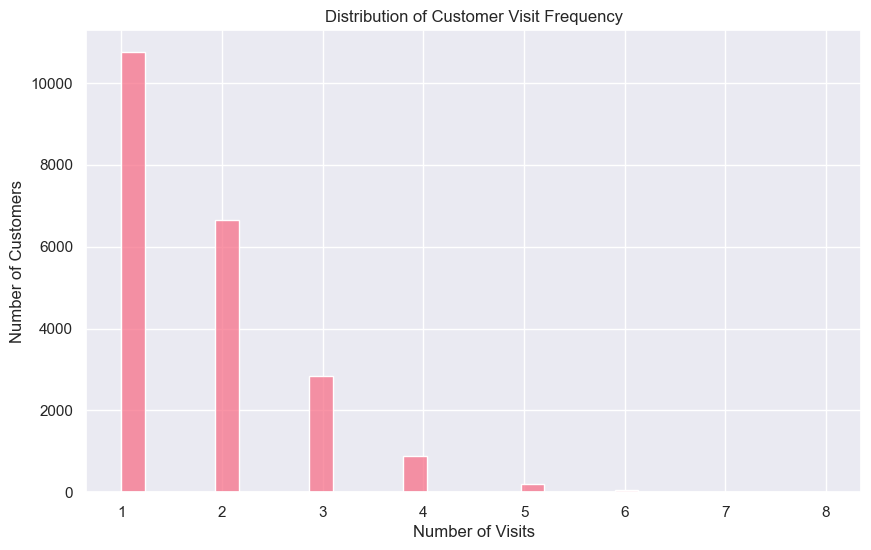

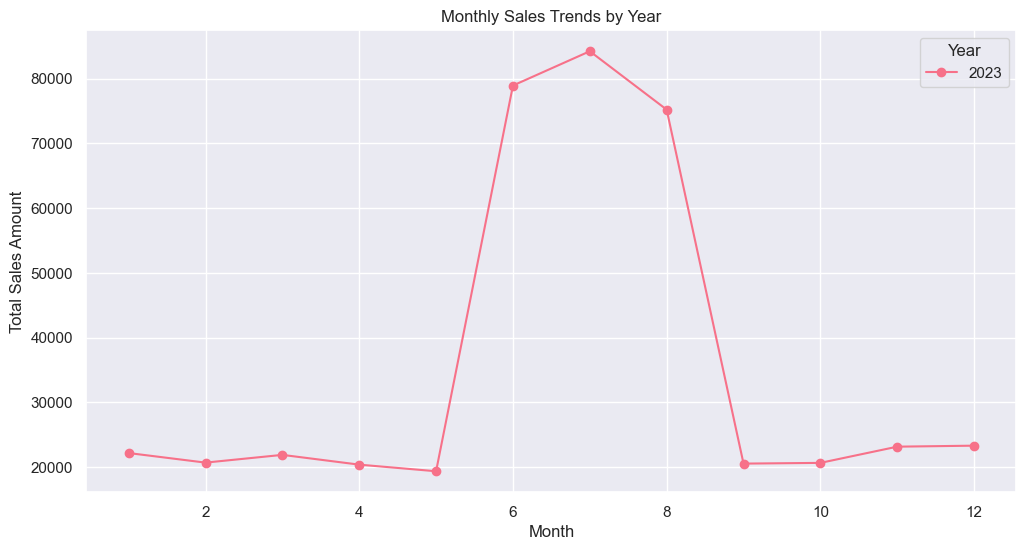

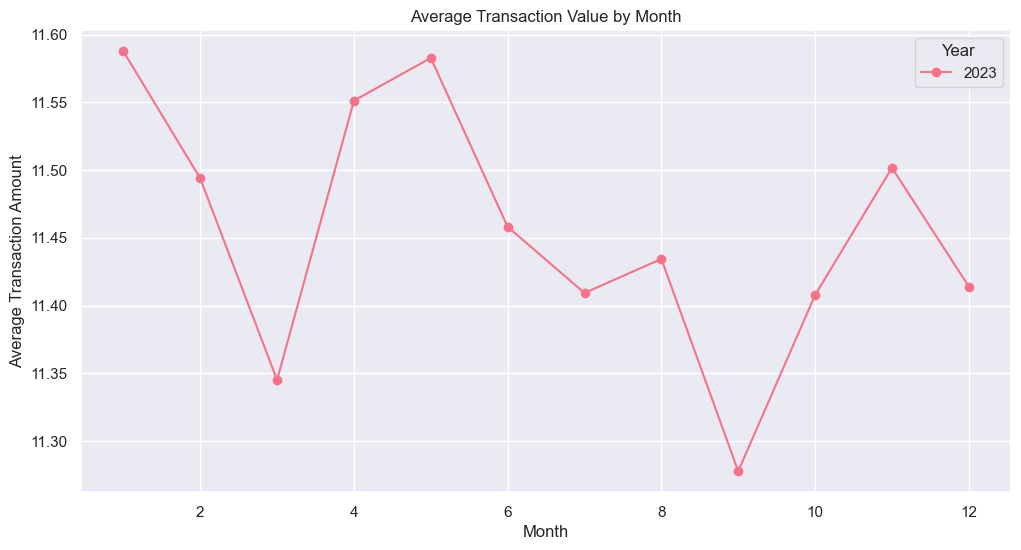

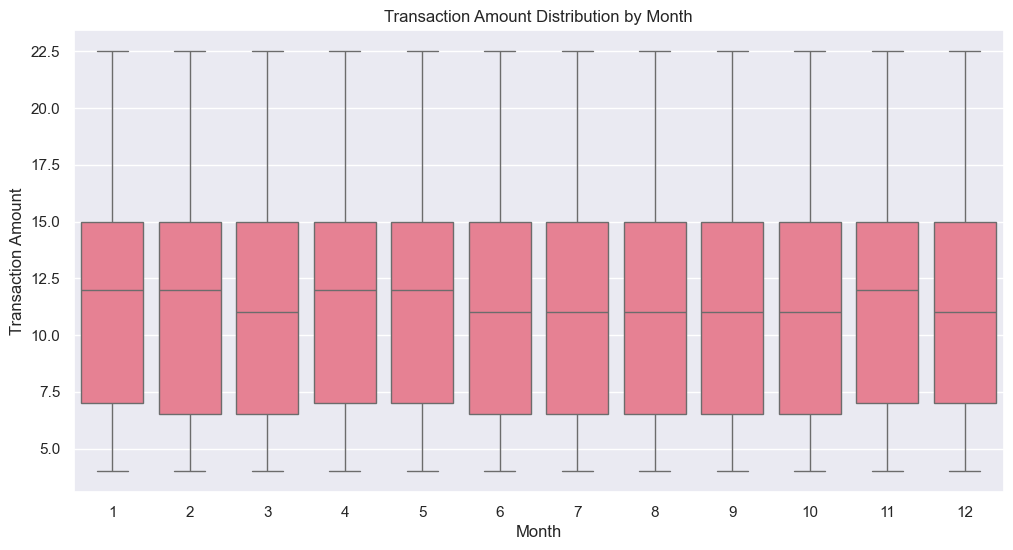

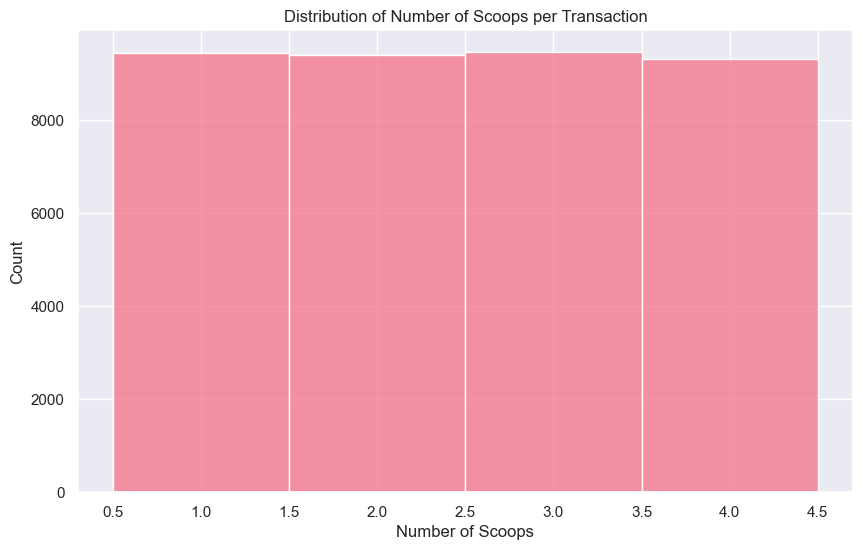

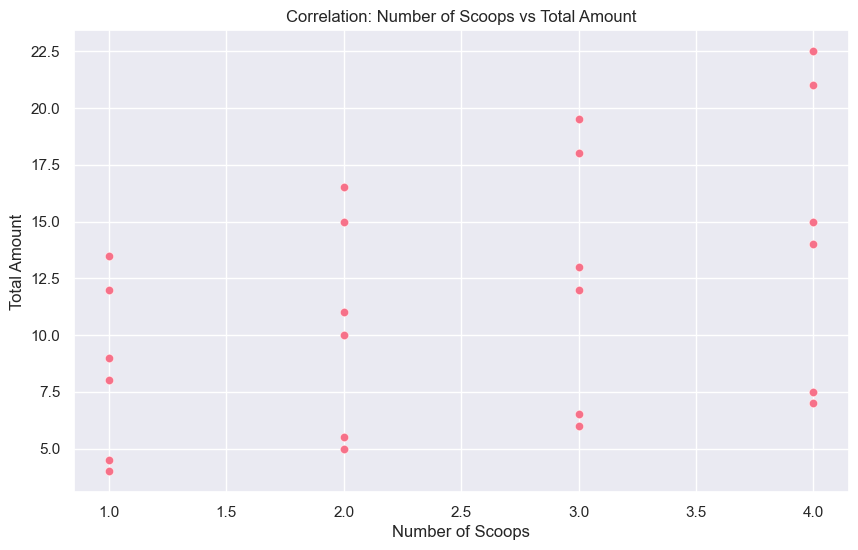

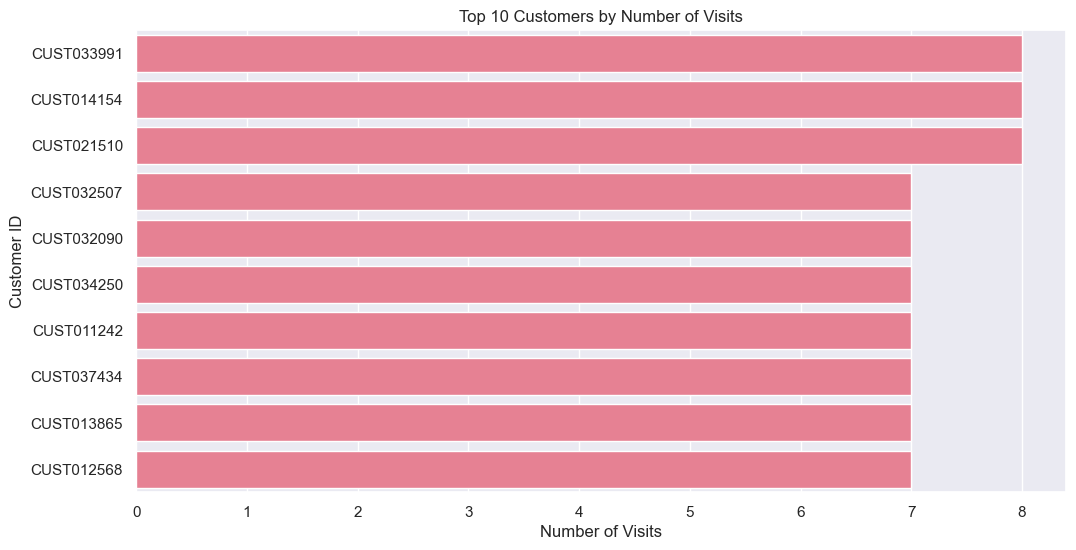


Visualizations have been generated and saved as separate PNG files:
1. monthly_transactions_heatmap.png
2. customer_visit_distribution.png
3. monthly_sales_trends.png
4. avg_transaction_by_month.png
5. transaction_amount_distribution.png
6. scoops_distribution.png
7. scoops_vs_total_correlation.png
8. top_10_customers.png

Key Correlations:
                        Number_of_Scoops_clean  Total_Amount_clean  \
Number_of_Scoops_clean                1.000000            0.421107   
Total_Amount_clean                    0.421107            1.000000   
Quantity_clean                        0.001912            0.885570   

                        Quantity_clean  
Number_of_Scoops_clean        0.001912  
Total_Amount_clean            0.885570  
Quantity_clean                1.000000  


In [20]:
# Create visualizations for summary statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the style
sns.set_theme()
sns.set_palette("husl")

# Helper function to save plots
def save_plot(plt, name):
    plt.savefig(f'{name}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# 1. Monthly Transaction Heatmap
plt.figure(figsize=(10, 6))
month_col = 'Month_clean' if 'Month_clean' in df.columns else 'Month'
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
pivot_data = df.groupby([month_col, year_col]).size().unstack()
sns.heatmap(pivot_data, annot=True, fmt='g', cmap='YlOrRd')
plt.title('Monthly Transaction Count by Year')
plt.xlabel('Year')
plt.ylabel('Month')
save_plot(plt, 'monthly_transactions_heatmap')

# 2. Customer Visit Frequency Distribution
plt.figure(figsize=(10, 6))
attendance_counts = df.groupby('Customer_ID').size()
sns.histplot(attendance_counts, bins=30)
plt.title('Distribution of Customer Visit Frequency')
plt.xlabel('Number of Visits')
plt.ylabel('Number of Customers')
save_plot(plt, 'customer_visit_distribution')

# 3. Monthly Sales Trends
plt.figure(figsize=(12, 6))
monthly_totals = df.groupby([year_col, month_col])['Total_Amount_clean'].sum().reset_index()
for year in monthly_totals[year_col].unique():
    year_data = monthly_totals[monthly_totals[year_col] == year]
    plt.plot(year_data[month_col], year_data['Total_Amount_clean'], marker='o', label=str(year))
plt.title('Monthly Sales Trends by Year')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.legend(title='Year')
plt.grid(True)
save_plot(plt, 'monthly_sales_trends')

# 4. Average Transaction Value by Month
plt.figure(figsize=(12, 6))
avg_transaction = df.groupby([year_col, month_col])['Total_Amount_clean'].mean().reset_index()
for year in avg_transaction[year_col].unique():
    year_data = avg_transaction[avg_transaction[year_col] == year]
    plt.plot(year_data[month_col], year_data['Total_Amount_clean'], marker='o', label=str(year))
plt.title('Average Transaction Value by Month')
plt.xlabel('Month')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Year')
plt.grid(True)
save_plot(plt, 'avg_transaction_by_month')

# 5. Transaction Amount Distribution by Month
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=month_col, y='Total_Amount_clean')
plt.title('Transaction Amount Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Transaction Amount')
save_plot(plt, 'transaction_amount_distribution')

# 6. Number of Scoops Distribution
plt.figure(figsize=(10, 6))
scoops_col = 'Number_of_Scoops_clean' if 'Number_of_Scoops_clean' in df.columns else 'Number_of_Scoops'
sns.histplot(data=df, x=scoops_col, discrete=True)
plt.title('Distribution of Number of Scoops per Transaction')
plt.xlabel('Number of Scoops')
plt.ylabel('Count')
save_plot(plt, 'scoops_distribution')

# 7. Correlation: Scoops vs Total Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=scoops_col, y='Total_Amount_clean', alpha=0.5)
plt.title('Correlation: Number of Scoops vs Total Amount')
plt.xlabel('Number of Scoops')
plt.ylabel('Total Amount')
save_plot(plt, 'scoops_vs_total_correlation')

# 8. Top 10 Customers
plt.figure(figsize=(12, 6))
top_customers = df.groupby('Customer_ID').size().sort_values(ascending=False).head(10)
sns.barplot(x=top_customers.values, y=top_customers.index)
plt.title('Top 10 Customers by Number of Visits')
plt.xlabel('Number of Visits')
plt.ylabel('Customer ID')
save_plot(plt, 'top_10_customers')

print("\nVisualizations have been generated and saved as separate PNG files:")
print("1. monthly_transactions_heatmap.png")
print("2. customer_visit_distribution.png")
print("3. monthly_sales_trends.png")
print("4. avg_transaction_by_month.png")
print("5. transaction_amount_distribution.png")
print("6. scoops_distribution.png")
print("7. scoops_vs_total_correlation.png")
print("8. top_10_customers.png")

# Calculate and print key correlations
print("\nKey Correlations:")
correlations = df[[scoops_col, 'Total_Amount_clean', 'Quantity_clean']].corr()
print(correlations)

## Sales Growth Forecasting (Train/Test Split)

This section introduces a minimal, interpretable sales growth forecasting workflow using the cleaned transaction data.

Approach:
- Aggregate total sales by Year/Month using cleaned columns (`Total_Amount_clean`, `Year_clean`, `Month_clean`).
- Construct a continuous monthly time index (YYYY-MM) and ensure chronological ordering.
- Perform a simple train/test split: last N months reserved for test (default N = 3 if >= 9 total months else N = 2, else fallback to leave 1 for test if possible).
- Baseline Forecast Methods:
  1. Naive (last observed month value).
  2. Seasonal Naive (value from same month previous year, if available; fallback to naive).
  3. Simple Moving Average (mean of last K months, K=3; requires enough history; fallback to naive).
- Metrics Computed on Test:
  - MAE (Mean Absolute Error)
  - RMSE (Root Mean Squared Error)
  - MAPE (Mean Absolute Percentage Error) with protection against division by zero
  - sMAPE (Symmetric MAPE)
  - Directional Accuracy (whether forecasted growth direction matches actual month-over-month change)
- Growth Calculation:
  - Month-over-month growth rate = (Current - Previous) / Previous for actuals & forecasts.

Assumptions:
- Data frequency is monthly and sufficiently dense; no gaps or missing months. If gaps exist, they are forward-filled with 0 sales for continuity.
- Cleaned columns exist; if not, raw columns are used with warnings.
- Sales amounts are non-negative.

Limitations:
- Does not model trend explicitly (no regression, ARIMA, or ETS components).
- Seasonal naive requires at least 12 months history; otherwise it reduces to naive.
- Moving average can lag turning points.
- MAPE can be distorted by near-zero actuals; sMAPE reduces this impact.

Outputs:
- Printed metric table.
- Plot of actual vs each forecast method over train/test period, saved to `forecast_comparison.png`.
- CSV `forecast_results.csv` containing per-test-month actuals and forecasts.

Next Steps (not implemented here):
- Evaluate advanced models (e.g., SARIMA, Prophet, Gradient Boosted Trees on lag features).
- Add holiday/promotion features.
- Conduct residual diagnostics and rolling-origin evaluation.


In [22]:
# Sales Growth Forecasting Code Cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Identify columns (fallbacks if clean not present)
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)

if not all([year_col, month_col, total_col]):
    raise ValueError('Required columns for forecasting (Year, Month, Total_Amount) not found.')

# Aggregate monthly sales
monthly = df.groupby([year_col, month_col])[total_col].sum().reset_index()
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)

# Coerce types
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])

# Build a date key (assumes Month 1..12)
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))

# Fill missing months if any (continuous range)
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
monthly_full = pd.DataFrame({'Date': full_range})
monthly_full = monthly_full.merge(monthly[['Date','Sales']], on='Date', how='left')
monthly_full['Sales'] = monthly_full['Sales'].fillna(0)  # assumption: missing months have zero sales

n_months = len(monthly_full)
if n_months < 4:
    raise ValueError(f'Not enough monthly data ({n_months} months) to perform a train/test split.')

# Determine test size
if n_months >= 9:
    test_size = 3
elif n_months >= 6:
    test_size = 2
else:
    test_size = 1

train = monthly_full.iloc[:-test_size].copy()
test = monthly_full.iloc[-test_size:].copy()

# Forecast methods
# 1) Naive: last observed sales value repeated
def naive_forecast(train_series, horizon):
    last_val = train_series.iloc[-1]
    return np.repeat(last_val, horizon)

# 2) Seasonal naive: value from same month previous year
# Requires at least 12 months history; fallback to naive if insufficient
months_in_year = 12
if len(train) >= months_in_year:
    def seasonal_naive_forecast(train_df, horizon):
        fc = []
        for i in range(horizon):
            target_date = test['Date'].iloc[i]
            prev_year_date = target_date - pd.DateOffset(years=1)
            match = train_df.loc[train_df['Date'] == prev_year_date, 'Sales']
            if not match.empty:
                fc.append(match.values[0])
            else:
                fc.append(train_df['Sales'].iloc[-1])  # fallback to last
        return np.array(fc)
else:
    seasonal_naive_forecast = lambda train_df, horizon: naive_forecast(train_df['Sales'], horizon)

# 3) Moving average (window=3) fallback to naive if insufficient history
def moving_average_forecast(train_series, horizon, window=3):
    if len(train_series) < window:
        return naive_forecast(train_series, horizon)
    avg_val = train_series.iloc[-window:].mean()
    return np.repeat(avg_val, horizon)

# Generate forecasts
h = test_size
naive_fc = naive_forecast(train['Sales'], h)
seasonal_fc = seasonal_naive_forecast(train, h)
ma_fc = moving_average_forecast(train['Sales'], h, window=3)

# Combine into DataFrame
results = test[['Date']].copy()
results['Actual'] = test['Sales'].values
results['Naive_Forecast'] = naive_fc
results['Seasonal_Naive_Forecast'] = seasonal_fc
results['MA3_Forecast'] = ma_fc

# Error metrics helpers
def safe_div(a,b):
    return np.where(b==0, np.nan, a/b)

def mae(a,f):
    return np.mean(np.abs(a-f))

def rmse(a,f):
    return np.sqrt(np.mean((a-f)**2))

def mape(a,f):
    return np.nanmean(np.abs(safe_div(a-f,a))) * 100

def smape(a,f):
    return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100

# Directional accuracy (growth direction)
# Growth defined vs previous actual for actual, previous forecast value for forecast
results['Actual_prev'] = test['Sales'].shift(1)
results['Naive_prev'] = naive_fc[:-1].tolist() + [naive_fc[-1]]  # simple shift approximation
# Compute growth direction actual & forecast (only where previous actual not NaN)
results['Actual_Growth'] = safe_div(results['Actual'] - results['Actual_prev'], results['Actual_prev'])
results['Naive_Growth'] = safe_div(results['Naive_Forecast'] - results['Actual_prev'], results['Actual_prev'])
# Directional accuracy where both growths available
direction_mask = results['Actual_Growth'].notna() & results['Naive_Growth'].notna()
if direction_mask.any():
    directional_accuracy = np.mean(np.sign(results.loc[direction_mask,'Actual_Growth']) == np.sign(results.loc[direction_mask,'Naive_Growth']))
else:
    directional_accuracy = np.nan

metrics_rows = []
for label, fc in [('Naive', 'Naive_Forecast'), ('Seasonal_Naive','Seasonal_Naive_Forecast'), ('MA3','MA3_Forecast')]:
    a = results['Actual'].values
    f = results[fc].values
    metrics_rows.append({
        'Model': label,
        'MAE': mae(a,f),
        'RMSE': rmse(a,f),
        'MAPE%': mape(a,f),
        'sMAPE%': smape(a,f)
    })
metrics_df = pd.DataFrame(metrics_rows)

print('--- Forecast Metrics (Test Set) ---')
print(metrics_df.round(3))
print('\nDirectional Accuracy (Naive growth direction):', round(directional_accuracy,3) if not np.isnan(directional_accuracy) else 'N/A')

# Plot actual vs forecasts
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
all_series = pd.concat([train, test])
ax.plot(train['Date'], train['Sales'], label='Train Actual', color='gray')
ax.plot(test['Date'], test['Sales'], label='Test Actual', color='black', linewidth=2)
ax.plot(results['Date'], results['Naive_Forecast'], label='Naive', linestyle='--')
ax.plot(results['Date'], results['Seasonal_Naive_Forecast'], label='Seasonal Naive', linestyle='--')
ax.plot(results['Date'], results['MA3_Forecast'], label='MA(3)', linestyle='--')
ax.set_title('Monthly Sales: Actual vs Baseline Forecasts')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
fig_path = 'forecast_comparison.png'
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f'Plot saved: {fig_path}')

# Export detailed results
export_df = results[['Date','Actual','Naive_Forecast','Seasonal_Naive_Forecast','MA3_Forecast']]
export_path = 'forecast_results.csv'
export_df.to_csv(export_path, index=False)
print(f'Results CSV saved: {export_path}')

# Brief textual interpretation
best_model = metrics_df.sort_values('MAE').iloc[0]['Model']
print('\nInterpretation:')
print(f'- Best baseline by MAE: {best_model}')
print('- Seasonal naive only adds value if >= 12 months history and pattern repeats. Check sMAPE for robustness when near-zero months exist.')
print('- Moving average smooths volatility but can lag sudden changes.')
print('- Consider adding trend/seasonality modeling for improved accuracy.')

# Guardrail info
print('\nGuardrails & Notes:')
print('- Missing months were filled with zero sales; this may understate seasonality amplitude.')
print('- MAPE can be inflated when actual values are near zero; sMAPE reduces this sensitivity.')
print('- Directional accuracy uses naive forecast growth direction as baseline comparator.')


--- Forecast Metrics (Test Set) ---
            Model        MAE       RMSE    MAPE%  sMAPE%
0           Naive   1833.000   2201.283    7.910   8.386
1  Seasonal_Naive   1833.000   2201.283    7.910   8.386
2             MA3  37633.667  37653.401  169.067  91.439

Directional Accuracy (Naive growth direction): 0.0
Plot saved: forecast_comparison.png
Results CSV saved: forecast_results.csv

Interpretation:
- Best baseline by MAE: Naive
- Seasonal naive only adds value if >= 12 months history and pattern repeats. Check sMAPE for robustness when near-zero months exist.
- Moving average smooths volatility but can lag sudden changes.
- Consider adding trend/seasonality modeling for improved accuracy.

Guardrails & Notes:
- Missing months were filled with zero sales; this may understate seasonality amplitude.
- MAPE can be inflated when actual values are near zero; sMAPE reduces this sensitivity.
- Directional accuracy uses naive forecast growth direction as baseline comparator.


In [2]:
# Rolling-Origin Backtest (Time-Series Cross-Validation) for Baselines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure base DataFrame is loaded if kernel restarted
if 'df' not in globals():
    df = pd.read_csv('2025.09.29_2023_Sales_Transactions_Only.csv')
    # Attempt minimal cleaning for key columns if cleaned versions missing
    if 'Total_Amount_clean' not in df.columns and 'Total_Amount' in df.columns:
        temp = df['Total_Amount'].astype(str).str.strip()
        temp = temp.replace('nan','',regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]','',regex=True)
        temp = temp.str.replace(r'[\$,\s]','',regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
    for c in ['Year','Month']:
        if f'{c}_clean' not in df.columns and c in df.columns:
            df[f'{c}_clean'] = pd.to_numeric(df[c], errors='coerce')

# Column resolution
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)
if not all([year_col, month_col, total_col]):
    raise ValueError('Required columns for backtest (Year, Month, Total_Amount) not found.')

monthly = df.groupby([year_col, month_col])[total_col].sum().reset_index()
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
series = (
    pd.DataFrame({'Date': full_range})
    .merge(monthly[['Date','Sales']], on='Date', how='left')
    .fillna({'Sales':0})
)

A = series['Sales'].values.astype(float)
D = series['Date']
N = len(series)
if N < 8:
    raise ValueError(f'Not enough months ({N}) for a meaningful rolling-origin backtest.')

min_train = 12 if N >= 18 else 6

# Metric helpers
def safe_div(a,b):
    b = np.asarray(b)
    return np.where(b==0, np.nan, a/b)

def mae(a,f):
    return np.nanmean(np.abs(a-f))

def rmse(a,f):
    return np.sqrt(np.nanmean((a-f)**2))

def mape(a,f):
    return np.nanmean(np.abs(safe_div(a-f,a))) * 100

def smape(a,f):
    return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100

rows = []
for t in range(min_train-1, N-1):
    train_slice = slice(0, t+1)
    y_train = A[train_slice]
    y_next = A[t+1]
    date_next = D.iloc[t+1]

    # Naive
    naive_pred = y_train[-1]

    # Seasonal Naive (12-month)
    if t+1-12 >= 0:
        seas_pred = A[t+1-12]
    else:
        seas_pred = naive_pred

    # MA(3)
    if len(y_train) >= 3:
        ma3_pred = np.nanmean(y_train[-3:])
    else:
        ma3_pred = naive_pred

    rows.append({
        'Date': date_next, 'Actual': y_next,
        'Naive': naive_pred,
        'Seasonal_Naive': seas_pred,
        'MA3': ma3_pred
    })

bt = pd.DataFrame(rows)

metrics = []
for name in ['Naive','Seasonal_Naive','MA3']:
    a = bt['Actual'].values
    f = bt[name].values
    metrics.append({'Model': name,
                    'MAE': mae(a,f),
                    'RMSE': rmse(a,f),
                    'MAPE%': mape(a,f),
                    'sMAPE%': smape(a,f)})
metrics_df = pd.DataFrame(metrics).round(3)
print("--- Rolling-Origin Backtest Metrics (1-step ahead, multiple folds) ---")
print(metrics_df)

# Save metrics
bt_metrics_path = 'rolling_backtest_metrics.csv'
metrics_df.to_csv(bt_metrics_path, index=False)
print(f'Metrics CSV saved: {bt_metrics_path}')

# Plot last 24 months of backtest results
plot_tail = min(24, len(bt))
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(bt['Date'].tail(plot_tail), bt['Actual'].tail(plot_tail), label='Actual', color='black', linewidth=2)
ax.plot(bt['Date'].tail(plot_tail), bt['Naive'].tail(plot_tail), label='Naive', linestyle='--')
ax.plot(bt['Date'].tail(plot_tail), bt['Seasonal_Naive'].tail(plot_tail), label='Seasonal Naive', linestyle='--')
ax.plot(bt['Date'].tail(plot_tail), bt['MA3'].tail(plot_tail), label='MA(3)', linestyle='--')
ax.set_title('Rolling-Origin Backtest: Last 24 Months (1-step ahead)')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plot_path = 'rolling_backtest_plot.png'
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f'Plot saved: {plot_path}')

--- Rolling-Origin Backtest Metrics (1-step ahead, multiple folds) ---
            Model        MAE       RMSE    MAPE%  sMAPE%
0           Naive  11963.333  22755.180   49.435  24.112
1  Seasonal_Naive  11963.333  22755.180   49.435  24.112
2             MA3  29144.806  35294.935  104.221  61.270
Metrics CSV saved: rolling_backtest_metrics.csv
Plot saved: rolling_backtest_plot.png


In [3]:
# SARIMA and Prophet Modeling Comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Reload monthly series (reuse logic)
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)
if not all([year_col, month_col, total_col]):
    raise ValueError('Required columns for advanced models not found.')

monthly = df.groupby([year_col, month_col])[total_col].sum().reset_index()
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
series = (
    pd.DataFrame({'Date': full_range})
    .merge(monthly[['Date','Sales']], on='Date', how='left')
    .fillna({'Sales':0})
)

# Train/Test (reuse same split logic)
N = len(series)
if N < 8:
    raise ValueError('Insufficient data for advanced comparison.')
if N >= 9:
    test_size = 3
elif N >= 6:
    test_size = 2
else:
    test_size = 1
train = series.iloc[:-test_size].copy()
test = series.iloc[-test_size:].copy()

# =============== SARIMA ===============
# Simple SARIMA config heuristic: (1,1,1) with seasonal (1,1,1,12) if length >= 24 else non-seasonal fallback
use_seasonal = N >= 24
order = (1,1,1)
seasonal_order = (1,1,1,12) if use_seasonal else (0,0,0,0)
try:
    sarima_model = SARIMAX(train['Sales'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_res = sarima_model.fit(disp=False)
    sarima_fc = sarima_res.forecast(steps=test_size).values
except Exception as e:
    print('SARIMA failed, falling back to naive. Error:', e)
    sarima_fc = np.repeat(train['Sales'].iloc[-1], test_size)

# =============== Prophet ===============
# Prepare data for Prophet
prophet_df = train[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
# Add simple yearly seasonality; Prophet auto-detects
try:
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=test_size, freq='MS')
    forecast = prophet_model.predict(future)
    prophet_fc = forecast.tail(test_size)['yhat'].values
except Exception as e:
    print('Prophet failed, falling back to naive. Error:', e)
    prophet_fc = np.repeat(train['Sales'].iloc[-1], test_size)

# Baseline naive for comparison
naive_fc = np.repeat(train['Sales'].iloc[-1], test_size)

# Metrics helpers
def safe_div(a,b):
    return np.where(b==0, np.nan, a/b)

def mae(a,f):
    return np.mean(np.abs(a-f))

def rmse(a,f):
    return np.sqrt(np.mean((a-f)**2))

def mape(a,f):
    return np.nanmean(np.abs(safe_div(a-f,a))) * 100

def smape(a,f):
    return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100

actual = test['Sales'].values
comparison = []
for name, fc in [('Naive', naive_fc), ('SARIMA', sarima_fc), ('Prophet', prophet_fc)]:
    comparison.append({'Model': name,
                       'MAE': mae(actual, fc),
                       'RMSE': rmse(actual, fc),
                       'MAPE%': mape(actual, fc),
                       'sMAPE%': smape(actual, fc)})
metrics_adv = pd.DataFrame(comparison).round(3)
print('\n--- Advanced Models vs Naive (Test Set) ---')
print(metrics_adv)

# Save metrics
adv_metrics_path = 'advanced_model_metrics.csv'
metrics_adv.to_csv(adv_metrics_path, index=False)
print(f'Metrics CSV saved: {adv_metrics_path}')

# Plot comparison
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train['Date'], train['Sales'], label='Train Actual', color='gray')
ax.plot(test['Date'], test['Sales'], label='Test Actual', color='black', linewidth=2)
ax.plot(test['Date'], naive_fc, label='Naive', linestyle='--')
ax.plot(test['Date'], sarima_fc, label='SARIMA', linestyle='--')
ax.plot(test['Date'], prophet_fc, label='Prophet', linestyle='--')
ax.set_title('Advanced Models Forecast Comparison')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
adv_plot_path = 'advanced_models_comparison.png'
fig.savefig(adv_plot_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f'Plot saved: {adv_plot_path}')

# Display quick ranking
best_adv = metrics_adv.sort_values('MAE').iloc[0]['Model']
print(f'Best model by MAE: {best_adv}')
print('Note: Prophet & SARIMA performance may be constrained by short history length.')

c:\Users\hanko\Documents\MSBA_Projects\quantic_msba_SIMP_anly_mthd_frmwk\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
14:58:04 - cmdstanpy - INFO - Chain [1] start processing
14:58:07 - cmdstanpy - INFO - Chain [1] done processing



--- Advanced Models vs Naive (Test Set) ---
     Model         MAE        RMSE     MAPE%   sMAPE%
0    Naive    1833.000    2201.283     7.910    8.386
1   SARIMA   10277.263   10362.751    45.790   37.219
2  Prophet  651451.676  750904.920  2965.932  178.792
Metrics CSV saved: advanced_model_metrics.csv
Plot saved: advanced_models_comparison.png
Best model by MAE: Naive
Note: Prophet & SARIMA performance may be constrained by short history length.
